In [1]:
import numpy as np
import pandas as pd
import os
import gc
import shap
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
import xgboost


In [2]:
df = pd.read_csv('train.csv')
X = df.drop(['row_id', 'time_id', 'target',"investment_id"], axis=1)
y = df["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=10)
del  X ,y,df

In [3]:
import os
print(os.cpu_count())

16


In [4]:
#model = xgboost.XGBRegressor().fit(X_train, y_train)


In [5]:
#model_Xgb_new=xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.05,n_jobs=4).fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_val, y_val)], verbose=False)
#model_Xgb_new.save_model('model_Xgb_new.json')
model_xgb = xgboost.XGBRegressor()
model_xgb.load_model("model_Xgb_new.json")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


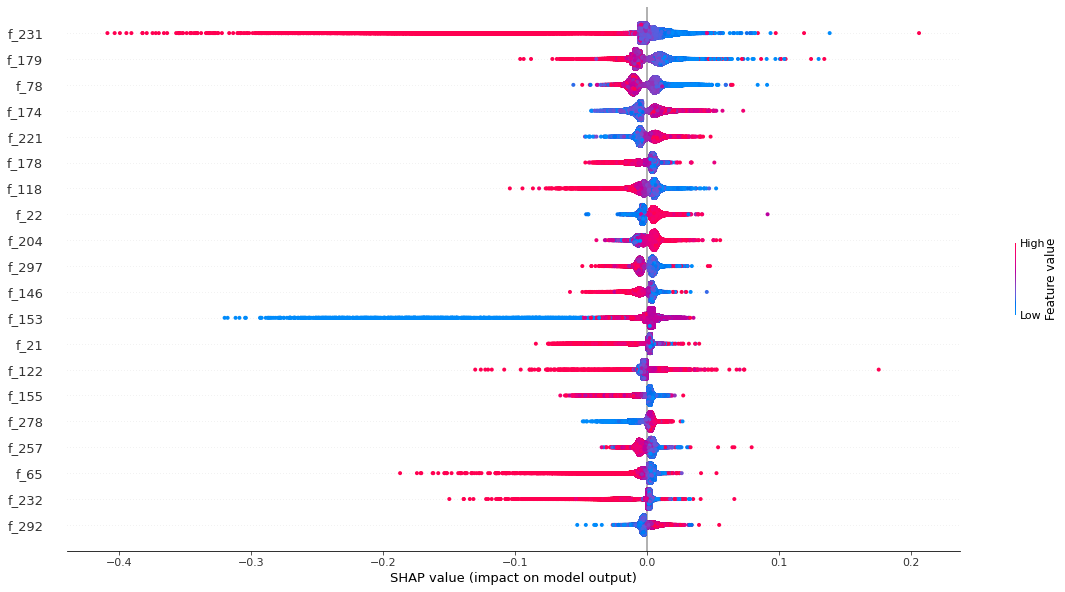

In [6]:
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val, plot_size=(20, 10))



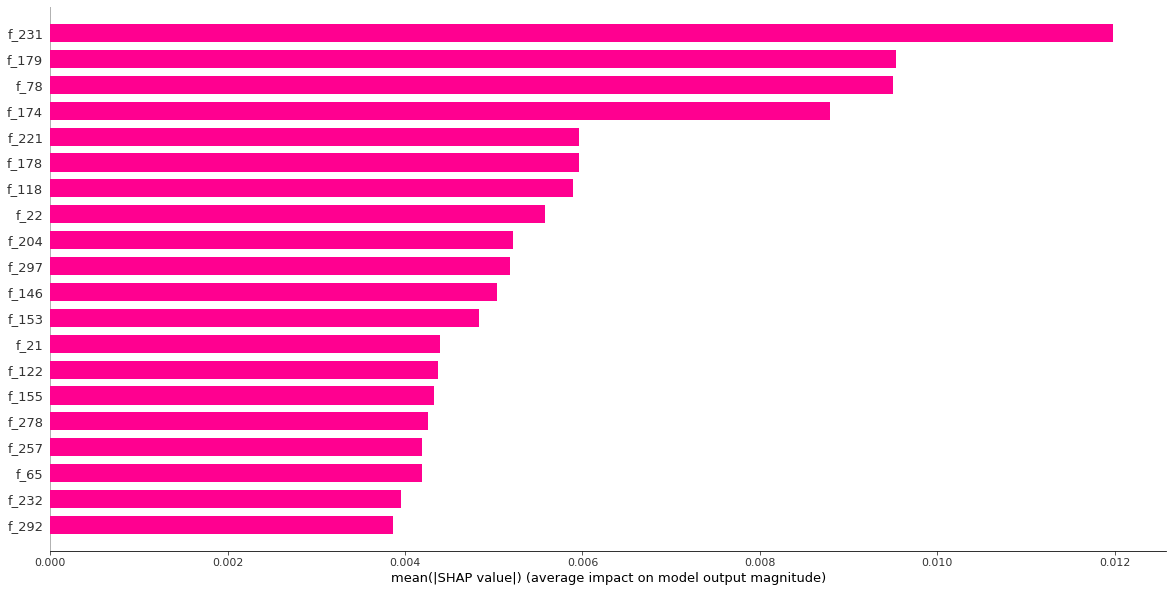

In [7]:
shap.summary_plot(shap_values, X_val, plot_type='bar', plot_size=(20, 10), color='#ff0090')


In [4]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
model = LGBMRegressor(
        num_leaves=30,
        learning_rate = 0.05,
        n_estimators = 1000,
        min_child_samples = 1000, 
        subsample=0.5, 
        metric="rmse"
    )
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
predictions = [round(value) for value in y_pred]
accuracy = mean_squared_error(y_val, predictions)
print("mse: %.2f%%" % (accuracy * 100.0))

mse: 80.53%


In [7]:
mse=0.8053
for i in range(10,100,30):
    for j in range(500,2500,700):
        model_new=LGBMRegressor(
        num_leaves=i,
        learning_rate = 0.05,
        n_estimators = 1000,
        min_child_samples = j, 
        subsample=0.5, 
        metric="rmse")
        model_new.fit(X_train, y_train)
        y_pred = model_new.predict(X_val)
        predictions = [round(value) for value in y_pred]
        mse_new = mean_squared_error(y_val, predictions)
        if mse_new<mse:
            mse=mse_new
            model=model_new
import joblib
joblib.dump(model,"lgbm_after_tunning.pkl")
        

        


['lgbm_after_tunning.pkl']

In [8]:
print(mse)

0.8051120976112496


In [9]:
model=joblib.load('lgbm_after_tunning.pkl') 

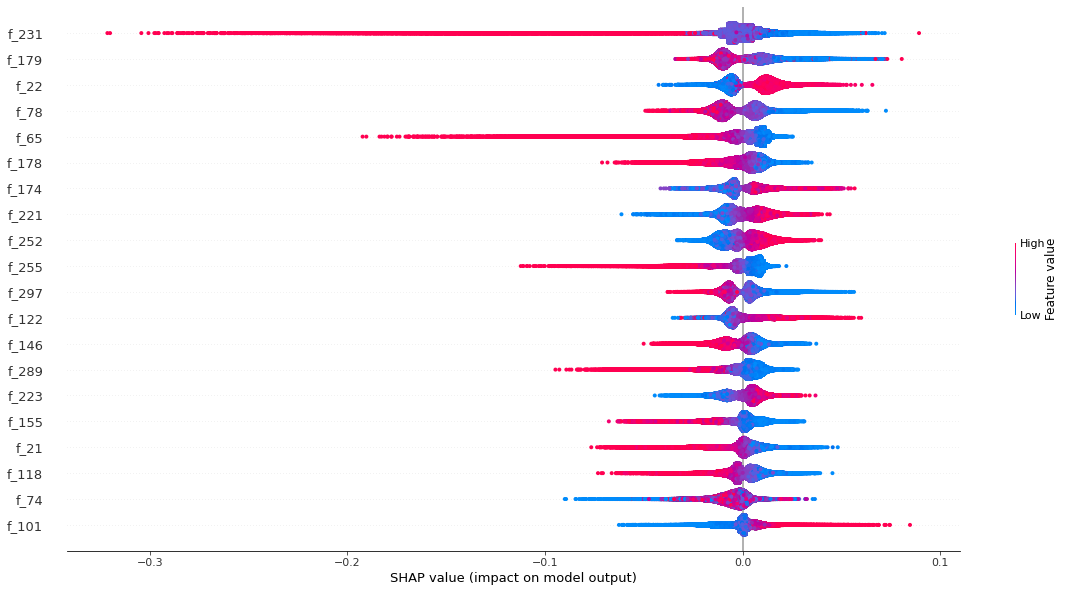

In [11]:
explainer = shap.Explainer(model)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val, plot_size=(20, 10))

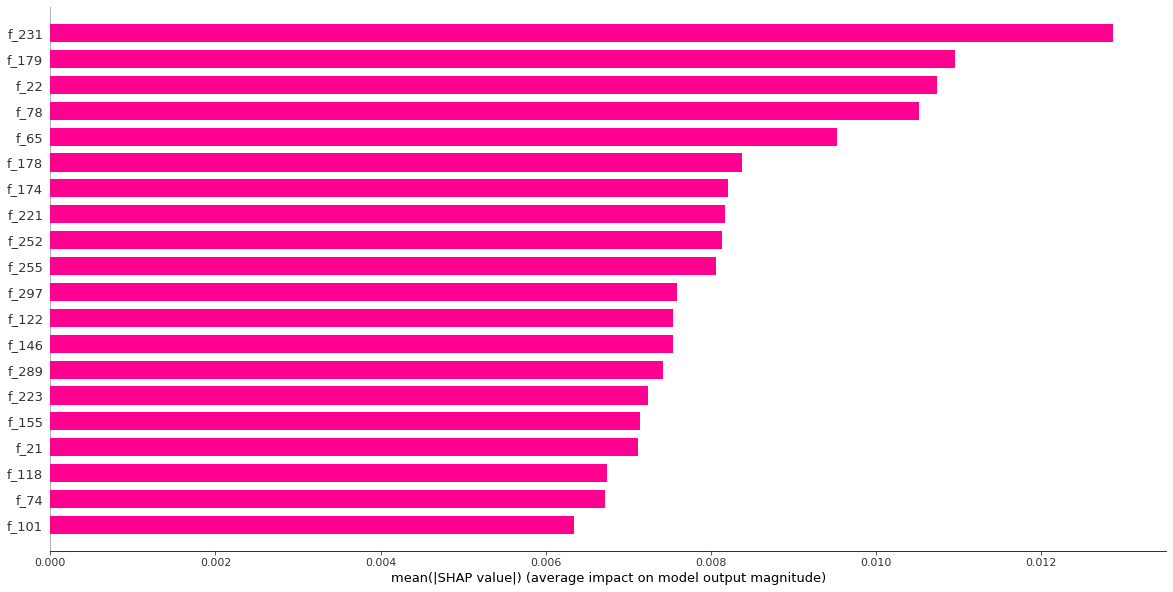

In [12]:
shap.summary_plot(shap_values, X_val, plot_type='bar', plot_size=(20, 10), color='#ff0090')


In [3]:
import torch
from torch.utils.data import Dataset,DataLoader,TensorDataset

X_train=torch.from_numpy(X_train.values).to('cuda')
X_val=torch.from_numpy(X_val.values).to('cuda')
y_train=torch.from_numpy(y_train.values).to('cuda')
y_val=torch.from_numpy(y_val.values).to('cuda')
train_dataset=TensorDataset(X_train,y_train)
test_dataset=TensorDataset(X_val,y_val)
trainloader=DataLoader(dataset=train_dataset,batch_size=128,shuffle=True)
testloader=DataLoader(dataset=test_dataset,batch_size=128,shuffle=True)

In [4]:
from torch import nn
from torch.nn import functional

In [19]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear=nn.Linear(300,1)
      

    def forward(self, x):
        linear_result = self.linear(x)
        result=40*torch.sigmoid(linear_result)-20
        return result.squeeze()

model = NeuralNetwork().to("cuda")
model=model.double()
print(model)

NeuralNetwork(
  (linear): Linear(in_features=300, out_features=1, bias=True)
)


In [20]:
learning_rate = 1e-3
batch_size = 32
epochs = 10
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [21]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            

    test_loss /= num_batches
    print(f" Avg loss: {test_loss:>8f} \n")

In [22]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, model, loss_fn, optimizer)
    test_loop(testloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 15.935552  [    0/2827269]
loss: 2.015139  [12800/2827269]
loss: 1.299408  [25600/2827269]
loss: 1.066039  [38400/2827269]
loss: 1.233729  [51200/2827269]
loss: 0.999218  [64000/2827269]
loss: 1.054516  [76800/2827269]
loss: 0.785959  [89600/2827269]
loss: 1.090010  [102400/2827269]
loss: 0.851476  [115200/2827269]
loss: 1.118388  [128000/2827269]
loss: 1.255027  [140800/2827269]
loss: 0.969517  [153600/2827269]
loss: 0.906286  [166400/2827269]
loss: 1.218654  [179200/2827269]
loss: 0.834795  [192000/2827269]
loss: 0.971356  [204800/2827269]
loss: 0.859063  [217600/2827269]
loss: 0.900532  [230400/2827269]
loss: 1.196037  [243200/2827269]
loss: 0.865662  [256000/2827269]
loss: 1.021593  [268800/2827269]
loss: 0.847607  [281600/2827269]
loss: 2.037567  [294400/2827269]
loss: 0.908362  [307200/2827269]
loss: 0.871393  [320000/2827269]
loss: 0.730421  [332800/2827269]
loss: 0.755351  [345600/2827269]
loss: 0.632163  [358400/2827269]
loss: 1.03

In [23]:

batch = next(iter(testloader))
X, y = batch

In [25]:
e = shap.DeepExplainer(model, X)
shap_values = e.shap_values(X)

IndexError: tuple index out of range

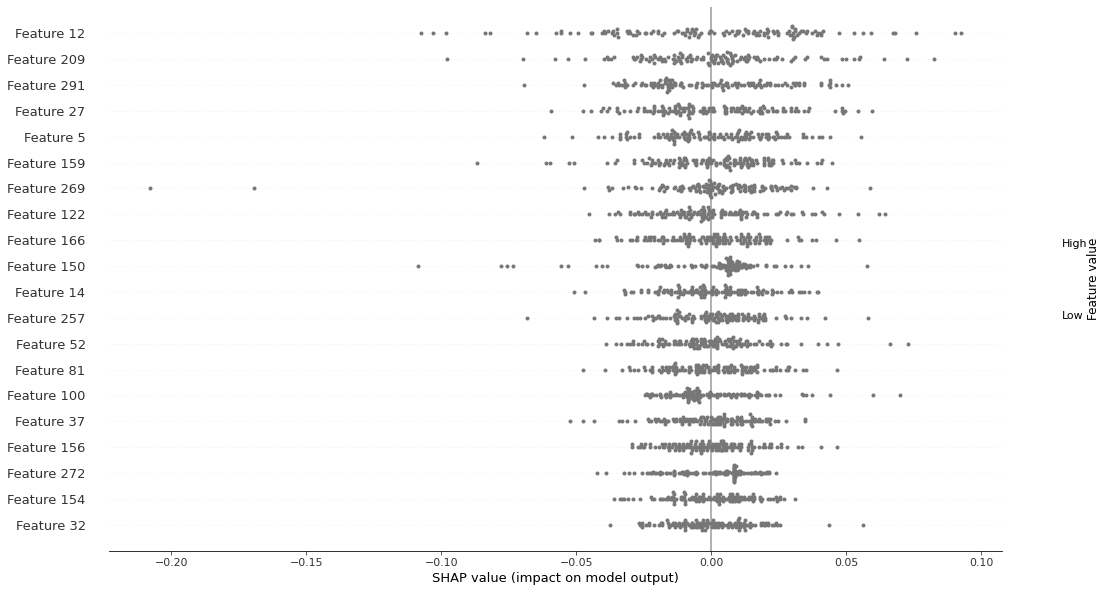

In [ ]:
shap.summary_plot(shap_values, X_val, plot_size=(20, 10))

In [26]:
torch.save(model, 'mlp.pth')